JuliaでGibbs samplingする

# 線形基底関数モデル(多項式回帰モデル)

## モデルの定義

線形基底関数モデルの同時分布

$$
\begin{align}
p(\mathbf{w}, \mathbf{Y} \mid \mathbf{X})=p(\mathbf{w}) p(\mathbf{Y} \mid \mathbf{X}, \mathbf{w})=p(\mathbf{w}) \prod_{n=1}^{N} p\left(y_{n} \mid \mathbf{x}_{n}, \mathbf{w}\right)
\end{align}
$$


観測モデル

$$
\begin{align}
p\left(y_{n} \mid \mathbf{x}_{n}, \mathbf{w}\right) = \mathcal{N}\left(y_{n} \mid f\left( \mathbf{w}, \mathbf{x}_{n}\right), \sigma_{y}^{2}\right)
\end{align}
$$

システムモデル

$$
\begin{align}
f\left( \mathbf{w}, \mathbf{x}_{n}\right) = \mathbf{w}^{\top} \mathbf{\phi}(\mathbf{x}_n)
\end{align}
$$

入力ベクトル

$$
\mathbf{\phi}(\mathbf{x}_n) = \left[x^0_n, x^1_n, \cdots, x^K_n \right]^{\top}
$$

$\mathbf{w}$の事前分布

$$
p(\mathbf{w})=\mathcal{N}\left(\mathbf{w} \mid 0, \sigma_{w}^{2} \mathbf{I}\right)
$$

## 解析解

$$
\begin{align}
p(\mathbf{w} \mid \mathbf{Y}, \mathbf{X}) &\propto p(\mathbf{w}) p(\mathbf{Y} \mid \mathbf{w}, \mathbf{X})  \\
  &= \mathscr{N}\left(y_{n} \mid \mathbf{w}^{T} \phi\left(\mathbf{x}_{n}\right), \sigma_{y}^{2}\right) \mathcal{N}\left(\mathbf{w} \mid 0, \sigma_{w}^{2} \mathbf{I}\right) \\
  &=\mathscr{N}(\mathbf{w} \mid \hat{\boldsymbol{\mu}}, \hat{\mathbf{\Sigma}}) \\
\hat{\mathbf{\Sigma}}^{-1} &= \sigma_{y}^{-2} \sum_{n=1}^{N} \phi\left(\mathbf{x}_{n}\right) \phi\left(\mathbf{x}_{n}\right)^{\top}+\sigma_{w}^{-2} \mathbf{I} \\
\hat{\mathbf{\mu}} &= \hat{\mathbf{\Sigma}} \sigma_{y}^{-2} \sum_{n=1}^{N} y_{n} \phi\left(\mathbf{x}_{n}\right)
\end{align}
$$

これを計画行列（Design Matrix）で書き直す（実装はDMでやるので）

$$
\begin{align}
p(\mathbf{w} \mid \mathbf{Y}, \mathbf{X}) &= \mathscr{N}(\mathbf{w} \mid \hat{\boldsymbol{\mu}}, \hat{\mathbf{\Sigma}}) \\
\hat{\mathbf{\Sigma}}^{-1} &= \sigma_{y}^{-2} \Phi^{\top}\Phi + \sigma_{w}^{-2} \mathbf{I} \\
\hat{\mathbf{\mu}} &= \sigma_{y}^{-2} \hat{\mathbf{\Sigma}} \Phi^{\top} \mathbf{y}
\end{align}
$$

ここで、DesignMatrixはこれ

$$
\begin{align}
\mathbf{\Phi}=\left(\begin{array}{cccc}
\phi_{0}\left(\mathbf{x}_{1}\right) & \phi_{1}\left(\mathbf{x}_{1}\right) & \cdots & \phi_{M-1}\left(\mathbf{x}_{1}\right) \\
\phi_{0}\left(\mathbf{x}_{2}\right) & \phi_{1}\left(\mathbf{x}_{2}\right) & \cdots & \phi_{M-1}\left(\mathbf{x}_{2}\right) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_{0}\left(\mathbf{x}_{N}\right) & \phi_{1}\left(\mathbf{x}_{N}\right) & \cdots & \phi_{M-1}\left(\mathbf{x}_{N}\right)
\end{array}\right)
\end{align}
$$

$M \times M$行列。$M$は特徴量次元。PRML(3章)参照

##　条件付き分布

線形回帰なので解析解は導出できるが、ギブスサンプリングで推論してみる。

推論対象の$\mathbf{w}$は基本的には2次元以上。そのため、$w_{-i}$(i番目以外のwという意味)を固定した、$w_i$についての条件付き分布からサンプルする。単変量の正規分布になるので、解析解の導出よりかはちょっと簡単かも?

$$
\begin{align*}
  p(w_i | w_{-i}, Y, X) &\propto \mathcal{N}(w_i | \hat{m}, \hat{\sigma}^2) \\
    \hat{\sigma}^{-2} &= \sigma^{-2}_w + \sigma^{-2}_y \sum^{N}_{n=1} \phi^2_i(x_n) \\
    \hat{m} &= \left( \sum^N_{n=1}y_n\phi_i(x_n) - \sum^N_{n=1}\alpha_n\phi_i(x_n) \right)\sigma^{-2}_y \hat{\sigma}^2 \\
    \alpha_n &= w_{-i}\phi_{-i}(x_n)
\end{align*}
$$


In [1]:
using PyPlot
using Distributions
using LinearAlgebra
using Random
Random.seed!(1);

## トイデータ

In [2]:
polynomial(x::Vector{Float64}; degree=3) = x .^(0:degree)';

function system_model(x::Vector{Float64}, w::Vector{Float64}; degree=3)
    dm = polynomial(x, degree=degree)
    y = dm * w
end

observation_model(y::Vector{Float64}; var=1.0) = y + (randn(length(y)) .* var);

観測データ

In [3]:
n_sample = 10;
x_low, x_high = -2., 2.
x = rand(n_sample) .* (x_high - x_low) .+ x_low;

w_t = [0., 0.1, -1.5, 0.5];
d = length(w_t) - 1;
y = system_model(x, w_t, degree=d);
var_z = 1.0
z = observation_model(y, var=var_z);

想定関数

In [4]:
x_t = Array(range(-3, 3; length=1000));
y_t = system_model(x_t, w_t, degree=d);

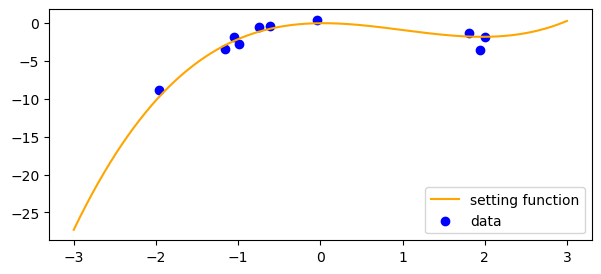

In [5]:
fig = figure(figsize=(7, 3));
ax = fig.subplots(1, 1);

ax.plot(x_t, y_t, color="orange", label="setting function");
ax.scatter(x, z, color="blue", label="data");
ax.legend();

## 実装

In [6]:
# wの事前分布のパラメータ
var_w = 1.0;

### 解析解

In [7]:
function as_linreg(Phi, z, var_z, var_w)
    Sig_hat_inv = var_z * Phi' * Phi + var_w*I;
    Sig_hat = inv(Sig_hat_inv);
    mu_hat = var_z * Sig_hat * Phi' * z;
    return (mu_hat, Sig_hat)
end

as_linreg (generic function with 1 method)

In [8]:
Phi = polynomial(x);

@time mu_hat, Sig_hat = as_linreg(Phi, z, var_z, var_w);

  5.225567 seconds (3.43 M allocations: 186.060 MiB, 1.49% gc time, 99.91% compilation time)


In [9]:
@time mu_hat, Sig_hat = as_linreg(Phi, z, var_z, var_w);

  0.000254 seconds (13 allocations: 4.062 KiB)


In [10]:
# r = MvNormal(mu_hat, Sig_hat);
r = MvNormal(mu_hat, Symmetric(Sig_hat));
n_sample = 1000
w_sample = rand(r, n_sample);

共分散行列`Sig_hat`に`Symmetric`という関数を設定しないと以下のエラーが出てMvNormからサンプルを取得できなかった。

```
ERROR: PosDefException: matrix is not Hermitian; Cholesky factorization failed.
```

ここでの解決策は、[ここ](https://discourse.julialang.org/t/multivariate-normal-with-positive-semi-definite-covariance-matrix/3029/14)のスレッドに書かれてたものを利用。けど、よくわからん。対称行列になっていると思うけど。。。`Symmetric`をした後の行列見ても同じように見えるが。。。

`Symmetric` -> 対称行列であるというタグを付与する。
数値誤差とかで厳密に対象になってなかったりするんだろうか？明示的に対称行列であるとする。（上三角の対称行列に変換される。下三角をコピーする場合は`:L`を追加する。[ここ](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.Symmetric)参照）

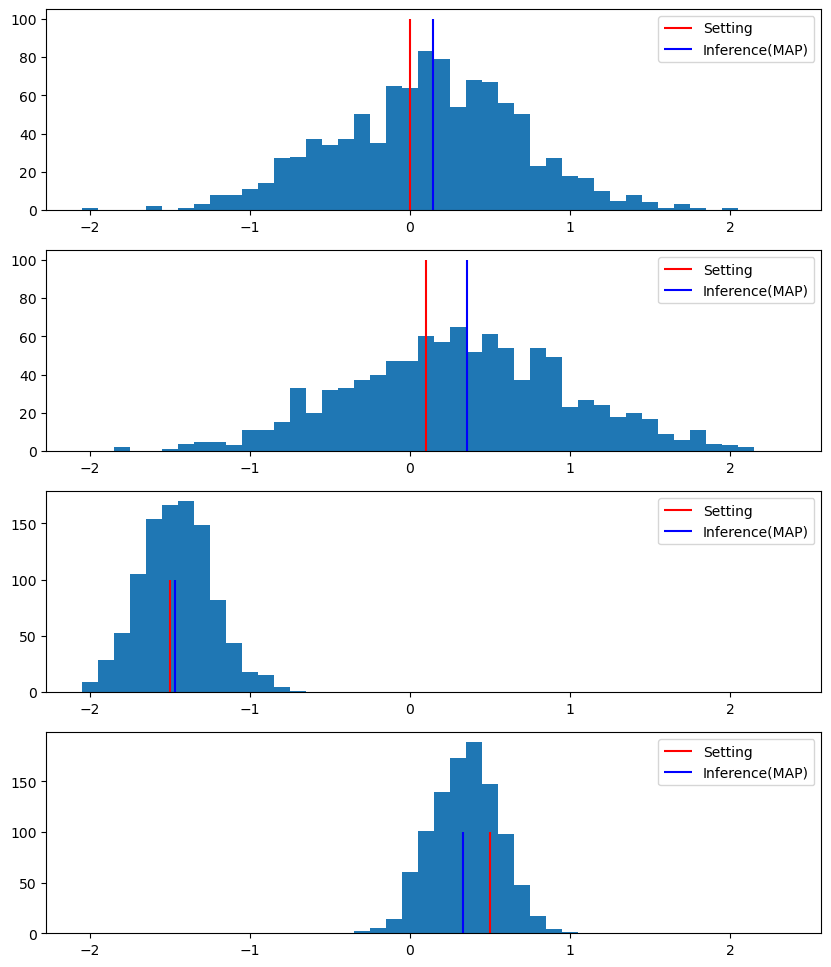

In [11]:
d = length(mu_hat)
fig = figure(figsize=(10, 3*d));
ax = fig.subplots(d, 1);

bins = range(minimum(w_sample), maximum(w_sample), step=0.1);
for i = 1:d
    ax[i].hist(w_sample[i,:], bins=bins);
    ax[i].vlines(w_t[i], 0, n_sample/10, "red", label="Setting");
    ax[i].vlines(mu_hat[i], 0, n_sample/10, "blue", label="Inference(MAP)");
    ax[i].legend();
end

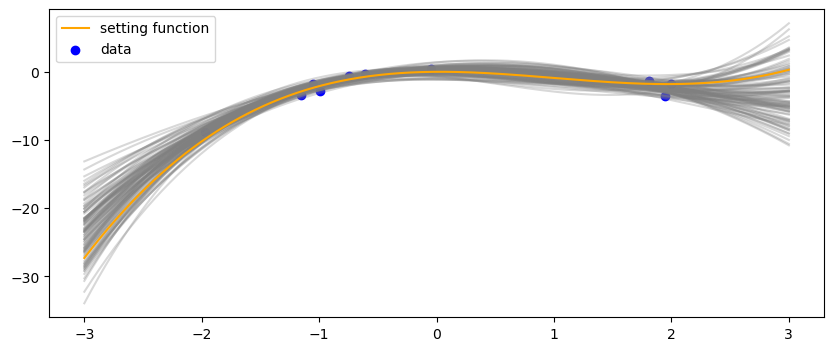

In [12]:
fig = figure(figsize=(10, 4));
ax = fig.subplots(1, 1);

n = 100
d = length(w_t) - 1;
idxs = sample(1:n_sample, n, replace=false)
x_plt = Array(range(-3, 3; length=1000));
for i = 1:n
    w_tmp = w_sample[:, idxs[i]];
    y_plt = system_model(x_plt, w_tmp, degree=d);
    ax.plot(x_plt, y_plt, color="gray", alpha=0.3);
end
ax.plot(x_t, y_t, color="orange", label="setting function");
ax.scatter(x, z, color="blue", label="data");
ax.legend();

### Gibbs sampling

In [13]:
function gs_linreg(Phi, d; n_sample=10000)
    w_buf = zeros(Float64, d)
    cnt = 1
    w_gs = zeros(Float64, d, n_sample+1)
    while cnt <= n_sample
        for d_i = 1:d
            var_hat_inv = (1.0/var_w) + (1.0/var_z) * Phi[:, d_i]' * Phi[:, d_i]
            var_hat = 1.0 / var_hat_inv
            
            not_i_idx = setdiff(1:d, d_i) # set (-i)indices
            alpha = Phi[:, not_i_idx] *  w_buf[not_i_idx]
            m_hat = (Phi[:, d_i]' * z - Phi[:, d_i]' * alpha) * (1.0/var_z) * var_hat
            
            r = Normal(m_hat, sqrt(var_hat))
            w_buf[d_i] = rand(r, 1)[1]
        end
        w_gs[:, cnt+1] = w_buf
        cnt += 1
    end
    return w_gs
end

gs_linreg (generic function with 1 method)

In [14]:
n_sample = 10000
burn_in = 500

d = length(w_t)
Phi = polynomial(x); # Design Matrix

@time w_gs = gs_linreg(Phi, d, n_sample=n_sample);

  2.152855 seconds (1.93 M allocations: 136.382 MiB, 3.12% gc time, 78.26% compilation time)


In [15]:
@time w_gs = gs_linreg(Phi, d, n_sample=n_sample);

  0.438684 seconds (1.24 M allocations: 94.910 MiB, 9.75% gc time)


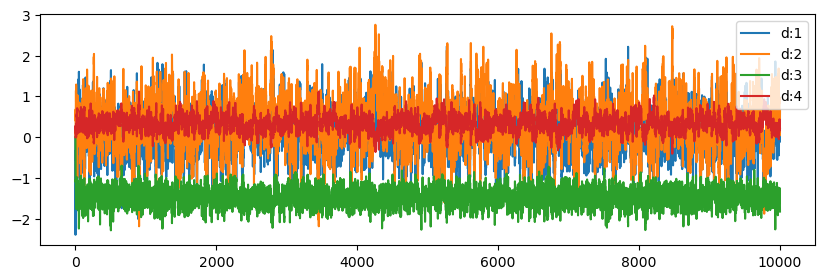

PyObject <matplotlib.legend.Legend object at 0x4089dac3d0>

In [16]:
fig = figure(figsize=(10, 3));
ax = fig.subplots(1, 1);

for i = 1:d
    ax.plot(w_gs[i,:], label="d:$i")
end
ax.legend()

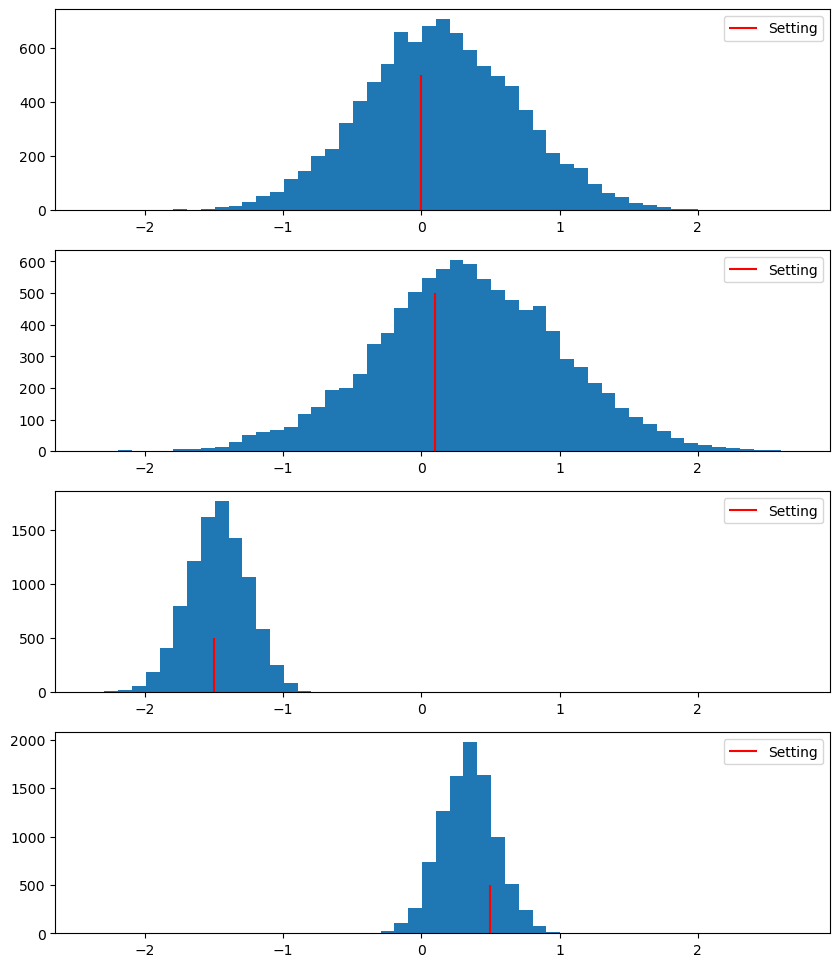

In [17]:
fig = figure(figsize=(10, 3*d));
ax = fig.subplots(d, 1);

bins = range(minimum(w_gs), maximum(w_gs), step=0.1);
for i = 1:d
    ax[i].hist(w_gs[i,burn_in:end], bins=bins);
    ax[i].vlines(w_t[i], 0, n_sample/20, "red", label="Setting");
    ax[i].legend();
end

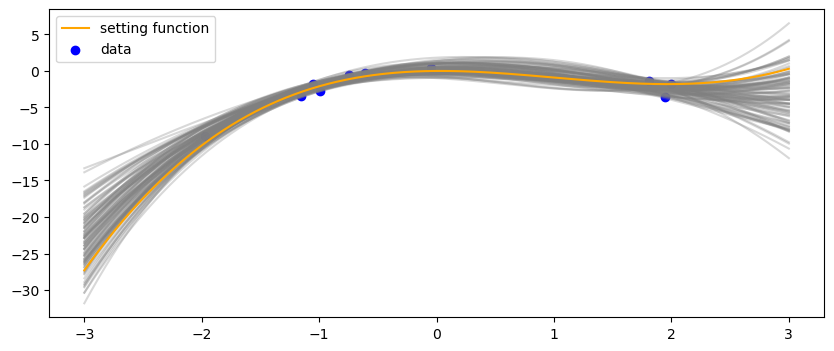

In [18]:
fig = figure(figsize=(10, 4));
ax = fig.subplots(1, 1);

n = 100
d = length(w_t) - 1;
idxs = sample(burn_in:n_sample, n, replace=false)
x_plt = Array(range(-3, 3; length=1000));
for i = 1:n
    w_tmp = w_gs[:, idxs[i]];
    y_plt = system_model(x_plt, w_tmp, degree=d);
    ax.plot(x_plt, y_plt, color="gray", alpha=0.3);
end
ax.plot(x_t, y_t, color="orange", label="setting function");
ax.scatter(x, z, color="blue", label="data");
ax.legend();